In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from sklearn.utils import resample
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import gc
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

pd.set_option('display.width', 200)

In [26]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')

In [27]:
# Train and test shapes
print(f"Train shape: {train_df.shape},\nTest shape: {test_df.shape}\n")

# Check class distribution in the training data
print(train_df['Response'].value_counts())

Train shape: (11504798, 12),
Test shape: (7669866, 11)

Response
0    10089739
1     1415059
Name: count, dtype: int64


In [28]:
# Combine train and test DataFrames to pre-process both in the same manner.
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0.0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1.0
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0.0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0.0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0.0


In [29]:
test_ids = test_df.id

In [30]:
# Drop id and Response columns
df = df.drop(['id', 'Response'], axis=1)

# Feature engineering

## Categorical to nummerical

In [31]:
# Encode categorical features with numerical values
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

In [32]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,0,21,1,35.0,0,1,1,65101.0,124.0,187
1,0,43,1,28.0,0,2,1,58911.0,26.0,288
2,1,25,1,14.0,1,0,0,38043.0,152.0,254
3,1,35,1,1.0,0,1,1,2630.0,156.0,76
4,1,36,1,15.0,1,1,0,31951.0,152.0,294


In [33]:
# Calculate correlations
corr_matrix = df.corr()

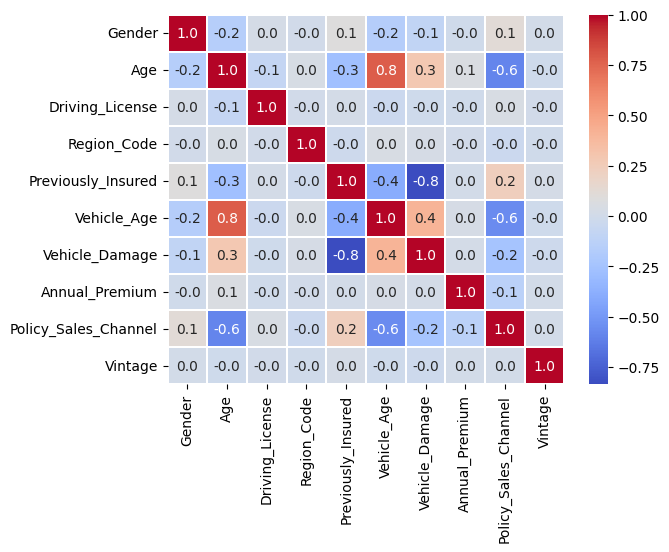

In [34]:
# Visualize correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.show();
# Some features have high correlation, pairwise, they do not carry useful information probably.

## Factorization of Raw Features

In [35]:
def feature_engineering(df):    
    # Concatenation and Factorization of Raw Features
    df = pl.DataFrame(df)
    df = df.with_columns([
        (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
        (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
        (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
        (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
    ])

    # Convert back to pandas DataFrame
    df = df.to_pandas()

    return df

df = feature_engineering(df)

In [36]:
# Calculate correlations
corr_matrix = df.corr()

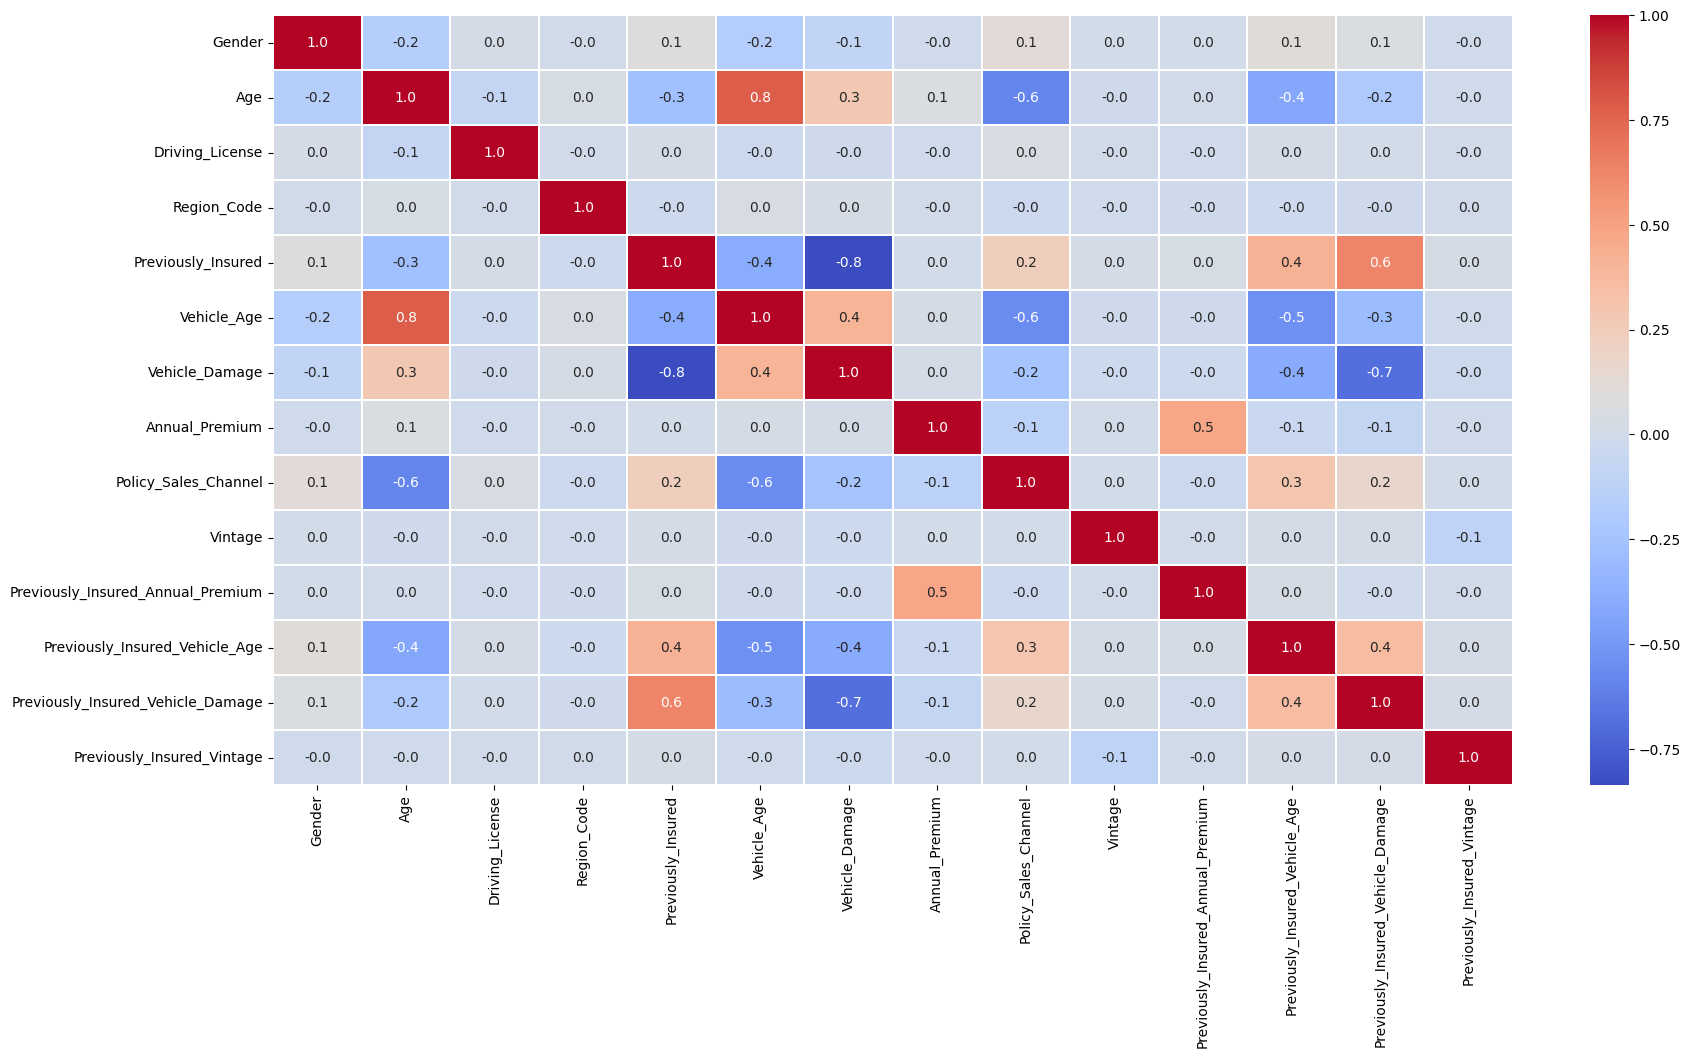

In [37]:
# Visu. correlations with new features
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.show();

In [38]:
df.tail()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
19174659,0,57,1,28.0,0,1,1,51661.0,124.0,109,8476,0,0,518
19174660,0,28,1,50.0,1,0,0,25651.0,152.0,184,28152,2,1,463
19174661,0,47,1,33.0,1,1,0,2630.0,138.0,63,18,3,1,115
19174662,0,30,1,28.0,0,0,1,38866.0,124.0,119,5806,4,0,247
19174663,0,23,1,46.0,1,0,0,27498.0,152.0,79,16482,2,1,320


## Scaling and normalizing

In [39]:
def scale_and_normalize(df):
    # Define the pipeline steps
    pipeline = Pipeline([
        ('scaler', StandardScaler()), # standardizing features by removing the mean and scaling to unit variance
        ('normalizer', MinMaxScaler()) # scales features to [0, 1] or [-1, 1] if negative values in dataset
    ])

    # Fit and transform the data
    combined_transformed = pipeline.fit_transform(df)

    # Convert back to DataFrame
    combined_transformed_df = pd.DataFrame(combined_transformed, columns=df.columns)

    return combined_transformed_df


transformed_df = scale_and_normalize(df)

In [40]:
# Display the first few rows
transformed_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage
0,0.0,0.015385,1.0,0.673077,0.0,0.5,1.0,0.116218,0.759259,0.612457,0.00000,0.0,0.000000,0.000000
1,0.0,0.353846,1.0,0.538462,0.0,1.0,1.0,0.104702,0.154321,0.961938,0.00001,0.2,0.000000,0.001727
2,1.0,0.076923,1.0,0.269231,1.0,0.0,0.0,0.065880,0.932099,0.844291,0.00002,0.4,0.333333,0.003454
3,1.0,0.230769,1.0,0.019231,0.0,0.5,1.0,0.000000,0.956790,0.228374,0.00003,0.0,0.000000,0.005181
4,1.0,0.246154,1.0,0.288462,1.0,0.5,0.0,0.054547,0.932099,0.982699,0.00004,0.6,0.333333,0.006908


# Prepare training data

## Get train set and labels from combined data set

In [41]:
# Extracting the features (all columns except 'Response')
X = transformed_df[:train_df.shape[0]]

# Extracting the target label ('Response')
y = train_df['Response']

# Verifying the separation
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11504798, 14)
y shape: (11504798,)


## Split train set into train and test set

In [42]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Prepare model, parameters and start training process

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.03,  # Reduced learning rate
    'alpha': 0.1,  # Slightly reduced regularization
    'subsample': 0.85,  # Increased subsample fraction
    'colsample_bytree': 0.45,  # Adjusted colsample_bytree
    'max_depth': 12,  # Reduced max depth
    'min_child_weight': 10,  # Slightly increased to control overfitting
    'gamma': 1e-6,  # Slightly increased gamma
    'random_state': 42,
    'max_bin': 35000,  # Reduced max_bin from 50000
    'enable_categorical': True,
    'n_estimators': 11000,  # Keep high for early stopping
    'tree_method': 'hist',
    'early_stopping_rounds': 100, 
}

gc.collect()

model = XGBClassifier(**params, device="cuda")

XGB = model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)],
    verbose=150
)

In [ ]:
print("Best iteration:", model.best_iteration)

# Run trained model on test set

In [ ]:
# Get test samples from combined data set
test_df = transformed_df[train_df.shape[0]:]

# Run model on test set
test_pred_probabilities = XGB.predict_proba(test_df)

# Extract probabilities of belonging to class 1
test_pred_prob_class1 = test_pred_probabilities[:, 1]
test_pred_prob_class1
# Define a threshold (0.5) to classify as 0 or 1
#threshold = 0.5

# Convert probabilities to binary predictions
#test_predictions = np.where(test_pred_prob_class1 > threshold, 1, 0)

In [ ]:
# Generate submission dataframe
output = pd.DataFrame({'id': test_ids,
                       'Response': test_pred_prob_class1})
output

In [ ]:
# Generate submission file
output.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')